# Photometric Stereo

The next cell loads 7 image sequences named

1. *chrome*,
2. *buddha*,
3. *cat*,
4. *gray*, 
5. *owl*,
6. *rock*, and
7. *horse*.

from `demoImages.zip`.  Each sequence has 12 images of an object (e.g. *budda*) taken under different illuminations, and the goal of this project is to reconstruct the surface normals of these objects by photometric stereo.

Fist upload `demoImages.zip` using the Colaboratory File Browser in the left pane, and then run the cell below.  It will load images into the following three dictionaries

* `bgr`: original BGR image,
* `gray`: grayscale version, and
* `mask`: binary image indicating the target region in the image.

For example, `bgr['budda'][0]` is the first image of *budda* sequence, given as $340{\times}512{\times}3$ `numpy.ndarray`. In other words, `bgr['budda']` is a set of images in NHWC format.


bgr: (12, 340, 512, 3)
gray: (12, 340, 512)
mask: (340, 512)
chrome sequence


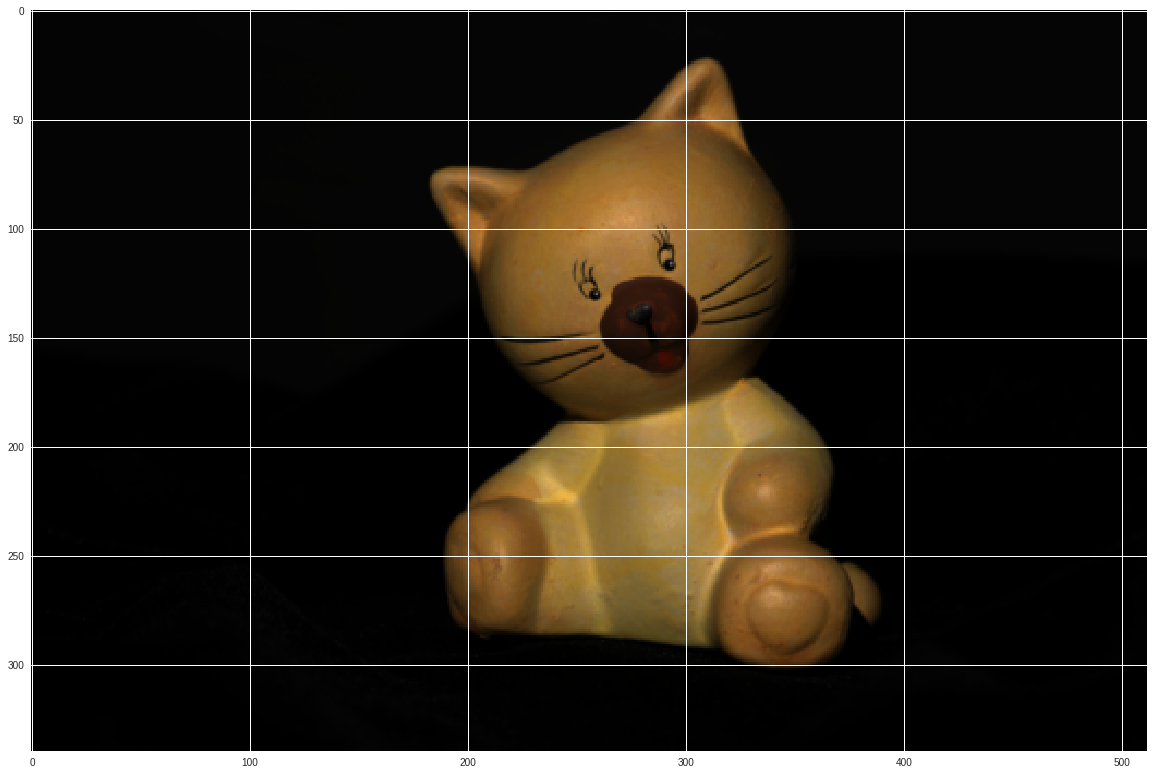

In [0]:
#@title Load Images
ZIP_FILE_NAME = "demo.zip" #@param {type:"string"}

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
import zipfile
import os
import random
import queue


rc('animation', html='jshtml')

def imread_z(zf, filename, flag=cv2.IMREAD_UNCHANGED):
    return cv2.imdecode(np.frombuffer(zf.read(filename), dtype='uint8'), flag)

Ni = 12
SUBJECT = ['chrome', 'buddha', 'cat', 'gray', 'owl', 'rock', 'horse', ]
bgr = {}
gray = {}
mask = {}

# check if the zip exists
assert os.path.exists(ZIP_FILE_NAME), 'Upload %s via Colab File Browser and then re-run the cell.' % ZIP_FILE_NAME
# load images from the zip
with zipfile.ZipFile(ZIP_FILE_NAME, mode='r') as zf:
    for s in SUBJECT:
        bgr[s] = np.array([imread_z(zf, '{0}/{0}.{1:d}.png'.format(s, x)) for x in range(Ni)])
        gray[s] = np.array([imread_z(zf, '{0}/{0}.{1:d}.png'.format(s, x), cv2.IMREAD_GRAYSCALE) for x in range(Ni)])
        mask[s] = imread_z(zf, '{0}/{0}.mask.png'.format(s), cv2.IMREAD_GRAYSCALE)


# check the size of a sequence
print('bgr:', bgr['chrome'].shape)
print('gray:', gray['chrome'].shape)
print('mask:', mask['chrome'].shape)

# show budda images by animation
print('chrome sequence')
tmp = bgr['cat']
fig = plt.figure()
ani = animation.ArtistAnimation(fig, [[plt.imshow(cv2.cvtColor(tmp[i], cv2.COLOR_BGR2RGB), animated=True)] for i in range(tmp.shape[0])], interval=100, blit=True, repeat_delay=1000)
ani


# To-Do

Fill in the following functions, in particular where denoted as follows.
```python
# TODO: ...
```


## 1. `comp_light()`

* Input: `chrome` gray and mask images
* Output: estimated light source directions as a $12{\times}3$ matrix. Each row corresponds to the lighting direction (3-dim vector) of each image.

## 2. `comp_normal()`

* Input: gray and mask images, and lighting directions
* Output: computed normal map as an $H{\times}W{\times}3$ matrix (= $H{\times}W$ 3D vector field)

## 3. `comp_albedo()`

* Input: BGR and mask images, lighting directions, and normal map
* Output: computed albedo as an $H{\times}W{\times}3$ BGR image

## 4. `comp_depth()`

* Input: mask image, lighting directions, and normal map
* Output: computed depth map as an $H{\times}W$ matrix



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in double_scalars


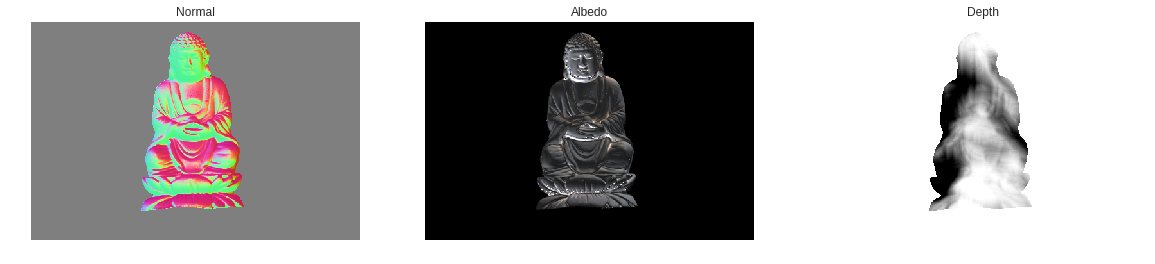

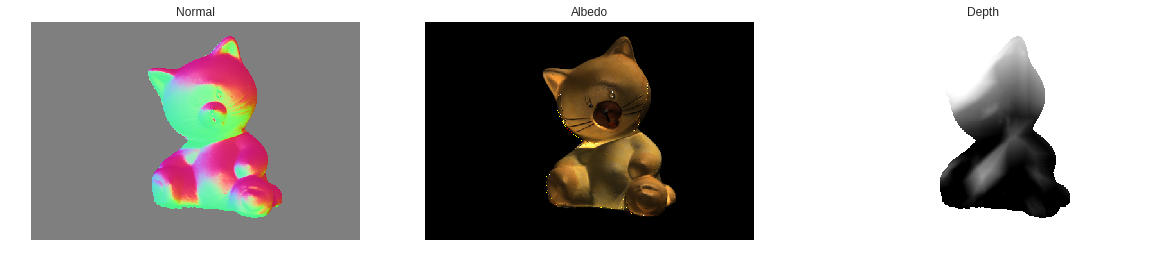

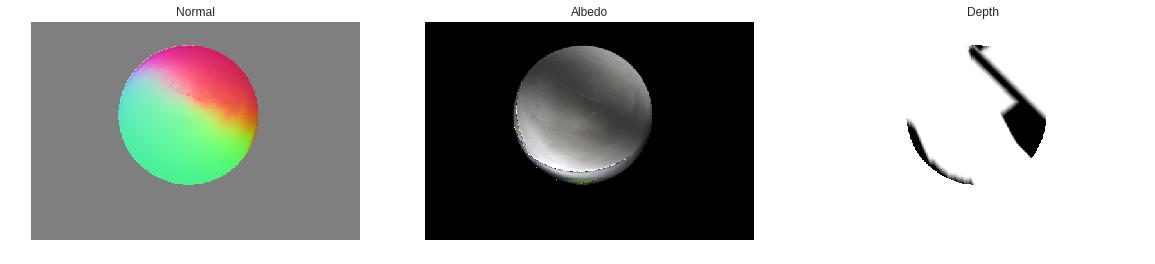

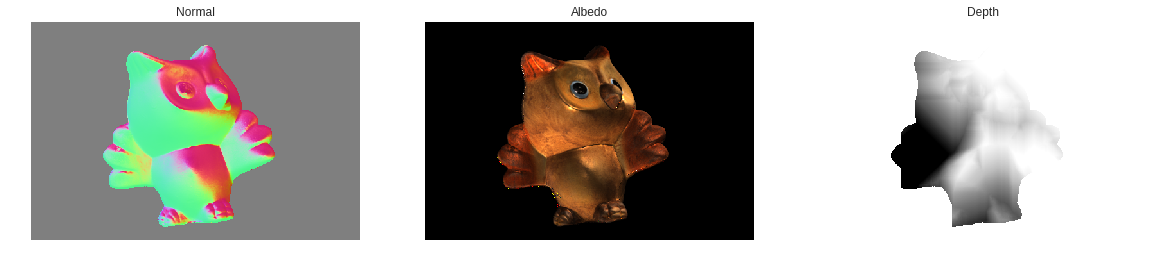

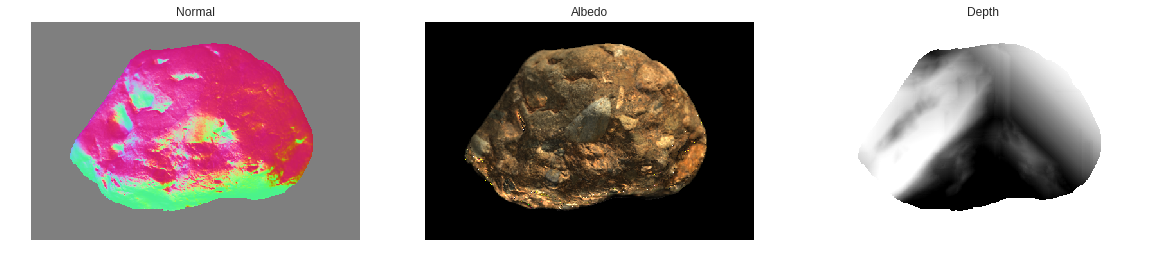

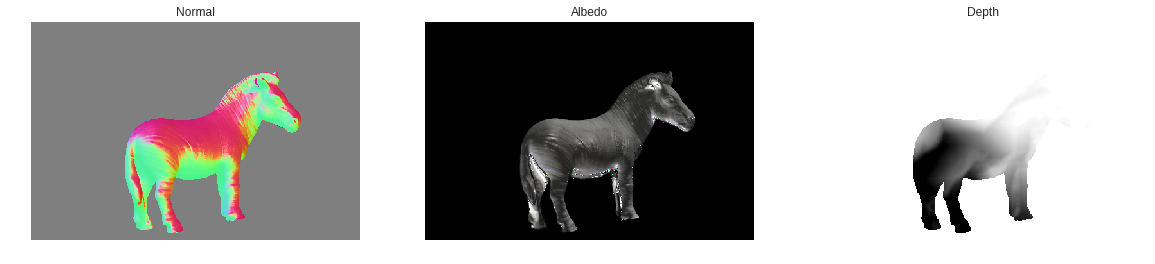

In [0]:
def comp_light(img, mask):
    """
    assume the viewer is at (0, 0, 1)
    """
    # Find the center and radius of the sphere from the mask
    ret, thresh = cv2.threshold(mask, 127, 255, 0)
    _, contours, _ = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    (cx, cy), cr = cv2.minEnclosingCircle(cnt)
    # plt.imshow(cv2.circle(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), (int(cx), int(cy)), int(cr), (0,255,0), 2))
    # plt.show()

    # Compute a weighted average of the brightest pixel locations.
    ret, thresh = cv2.threshold(img, 230, 255, 0)
    _, contours, _ = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    M = cv2.moments(cnt)
    hx = M['m10']/M['m00']
    hy = M['m01']/M['m00']
    # plt.imshow(cv2.circle(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), (int(hx), int(hy)), 3, (0, 255, 0), 1))
    # plt.show()

    
    # TODO: Compute the surface normal at the point
    dz = (cr**2-(hx-cx)**2-(hy-cy)**2)**0.5
    N = np.array([hx-cx,hy-cy,dz])/cr
    R = np.array([0,0,1])-np.array([hx,hy,0])
    
    # TODO: Compute light source direction from normal
    S = 2*(np.dot(N,R))*N-R
    S = S/np.linalg.norm(S) 

    return S

def comp_normal(g, m, l):
    S=l
    St=S.transpose()
    Sr = np.matmul(np.linalg.inv(np.matmul(St,S)),St)
    nmap = np.zeros((m.shape[0], m.shape[1], 3))
    for x in range(m.shape[0]):
        for y in range(m.shape[1]):
            if (m[x][y]==0): continue
            # TODO: Compute the normal at (x, y) from the pixel values, the light directions.
            I=np.array([g[k][x][y] for k in range(12)],dtype=np.float32)
            nhat=np.matmul(Sr,I)
            if (np.linalg.norm(nhat)>0.0000001):
                nmap[x][y]=nhat/np.linalg.norm(nhat)
    return nmap

def comp_albedo(bgrs, mask, lights, nmap):
    S = lights
    amap = np.zeros((mask.shape[0], mask.shape[1], 3))
    maxMap = [[],[],[]] 
    sumMap = np.zeros(3)
    easyMap = np.zeros(3)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if (mask[x][y]!=0):
                for k in range(3):
                    I = np.array([bgrs[it][x][y][k]for it in range(12)])
                    N = nmap[x][y]
                    SN = np.matmul(S,N)
                    amap[x][y][k]=np.abs((np.mean([I[it]/(SN[it]+0.00000000001) for it in range(12)])))
                    maxMap[k].append(amap[x][y][k])
    standRatio = int(len(maxMap[k])*0.99)
    for k in range(3):
        maxMap[k].sort()
        easyMap[k] = (maxMap[k][standRatio])
    for k in range(3):
        sumMap[k] = np.sum(maxMap[k][:standRatio])
    ratioMap = [sumMap[k]/np.max(sumMap) for k in range(3)]
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if (mask[x][y]!=0):
                for k in range(3):
                    amap[x][y][k]=amap[x][y][k]/easyMap[k]*ratioMap[k]
                    if (amap[x][y][k]>=1):
                        amap[x][y][k]=0.999
    return amap
def comp_depth(m, nmap):
    """
    Use the origin method, first assign some point with depth==0 (line 106)
    Then use nx+nz(z(x+1,y)-z(x,y))==0 to solve adjacent points, (line 119 to 126)
    Using a relex method, add points to the queue when the value changes.(line 127)
    Sorry for the bad result.
    """
    lenx = m.shape[0]
    leny = m.shape[1]
    startx = -1 
    starty = -1
    
    d = np.zeros((lenx,leny))
    flag = np.zeros((lenx,leny))
    for i in range(lenx):
        for j in range(leny):
            if (m[i][j]>0):
                startx=i
                starty=j
                break
        if (startx>0): break

    q = queue.Queue()
    dx = [0,1,0,-1]
    dy = [1,0,-1,0]

    d[startx][starty]=0
    flag[startx][starty]=1
    q.put((startx,starty))
    nn =0
    dL=[]

    while (q.empty()==0):
        nowx,nowy=q.get()
        for i in random.sample(range(4),4):
            newx = nowx+dx[i]
            newy = nowy+dy[i]
            if (newx>=0 and newx<lenx and newy>=0 and newy<leny):
                if (m[newx][newy]>0):
                    tmpd =-(dx[i]*nmap[newx][newy][0]+dy[i]*nmap[newx][newy][1])/nmap[newx][newy][2]
                    if (tmpd>0.10): tmpd=0.10
                    if (tmpd<-0.10): tmpd=-0.10
                    #if (tmpd>1): tmpd=1
                    #if (tmpd<-1): tmpd=-1
                    tmpd+=d[nowx][nowy]
                    times=float(flag[newx][newy])
                    newt=(tmpd/(times+1)+d[newx][newy]*times/(times+1))
                    if (flag[newx][newy]==0 or abs(newt-d[newx][newy])>0.1):
                        d[newx][newy]=newt
                        q.put((newx,newy))
                        flag[newx][newy]+=1
                    else:
                        dL.append(d[newx][newy])
    dL.sort()                    
    dLLen = len(dL)
    mind = dL[int(0.06*dLLen)]
    maxd = dL[int(0.9*dLLen)]
    lend = maxd-mind
    for i in range(lenx):
        for j in range(leny):
            if (m[i][j]==0):continue
            d[i][j]=(d[i][j]-mind)/lend
            if (d[i][j]<=0): d[i][j]=0.001
            if (d[i][j]>=1): d[i][j]=0.999
    #plt.imshow(d)
    return d

#def comp_depth(mask, nmap):
#    A = sp.lil_matrix((mask.size * 2, mask.size))
#    b = np.zeros(A.shape[0])
#    for y in range(mask.shape[0]):
#        for x in range(mask.shape[1]):
#            #  TODO: Fill in A and b
#            pass
#
#    # Solve Ax=b
#    AtA = A.transpose().dot(A)
#    Atb = A.transpose().dot(b)
#    x, info = sp.linalg.cg(AtA, Atb)
#    d = x.reshape(mask.shape)
#    d[mask == 0] = 0
#    return d
#

def save_as_ply(filename, dmap, nmap, a_bgr, mask):
    Np = np.count_nonzero(mask)
    bgr = (a_bgr * 255).astype(np.uint8)
    with open(filename, 'w') as fp:
        fp.write('ply\n')
        fp.write('format ascii 1.0\n')
        fp.write('element vertex {0}\n'.format(Np))
        fp.write('property float x\n')
        fp.write('property float y\n')
        fp.write('property float z\n')
        fp.write('property float nx\n')
        fp.write('property float ny\n')
        fp.write('property float nz\n')
        fp.write('property uchar blue\n')
        fp.write('property uchar green\n')
        fp.write('property uchar red\n')
        fp.write('end_header\n')
        for y in range(dmap.shape[0]):
            for x in range(dmap.shape[1]):
                if mask[y, x] == 0:
                    continue
                fp.write('{0:e} {1:e} {2:e} {3:e} {4:e} {5:e} {6:d} {7:d} {8:d}\n'.format(x, y, dmap[y, x], nmap[y, x, 0], nmap[y, x, 1], nmap[y, x, 2], bgr[y, x, 0], bgr[y, x, 1], bgr[y, x, 2]))
                

# plot size
from pylab import rcParams
rcParams['figure.figsize'] = 20,20


# compute light directions
lights = np.zeros((Ni, 3))
for i in range(Ni):
    lights[i, :] = comp_light(gray['chrome'][i], mask['chrome'])

normal = {}
albedo = {}
depth = {}
for s in SUBJECT:
    if s == 'chrome':
        continue

    fig, ax = plt.subplots(1, 3)
    for a in ax:
        a.grid(False)
        a.axis('off')

    # compute normal map in [-1:1]
    n = comp_normal(gray[s], mask[s], lights)
    ax[0].imshow((n+1)/2)
    ax[0].set_title('Normal')

    # compute albedo image in [0:1]
    a_bgr = comp_albedo(bgr[s], mask[s], lights, n)
    ax[1].imshow(np.flip(a_bgr, 2))
    ax[1].set_title('Albedo')

    # compute depth image
    d = comp_depth(mask[s], n)
    ax[2].imshow(d)
    ax[2].set_title('Depth')

    plt.show()
    
    normal[s] = n
    albedo[s] = a_bgr
    depth[s] = d

    # save as ply, to render with MeshLab (http://www.meshlab.net/)
    save_as_ply('{0}.ply'.format(s), d, n, a_bgr, mask[s])



# 3D plot of depth-maps

The next cell plots the estimated depth maps by assuming that the previous cell saves the depth-maps into a dictionary named `depth`.


In [0]:
import plotly.plotly as py
import numpy as np
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter
import IPython

def configure_plotly_browser_state():
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
    
configure_plotly_browser_state()
init_notebook_mode(connected=False)

def plot3d(d, title):
    data = [ go.Surface(z=np.flipud(d)) ]

    layout = go.Layout(
        title=title,
        autosize=True,
        width=500,
        height=500,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename=title)

for s in SUBJECT:
    if s == 'chrome':
        continue
    plot3d(depth[s], s)